In [5]:
import numpy as np
import torch
from PIL import Image
from matplotlib import pyplot as plt
import os
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


#### Define Helper Functions:

In [3]:
def dplot(img, name):
    """
    Plot and save a complex image.
    Handles various input shapes and ensures proper conversion.
    """

    if torch.is_complex(img):
        img = torch.abs(img)
    
    img_np = img.detach().cpu().numpy()

    while img_np.ndim > 2:
        img_np = np.squeeze(img_np, axis=0)
    
    if img_np.ndim == 3:
        img_np = img_np[0]
    
    if img_np.ndim != 2:
        raise ValueError(f"Failed to convert tensor to 2D array. Current shape: {img_np.shape}")
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img_np, cmap='gray')
    plt.colorbar()
    plt.title(name)
  

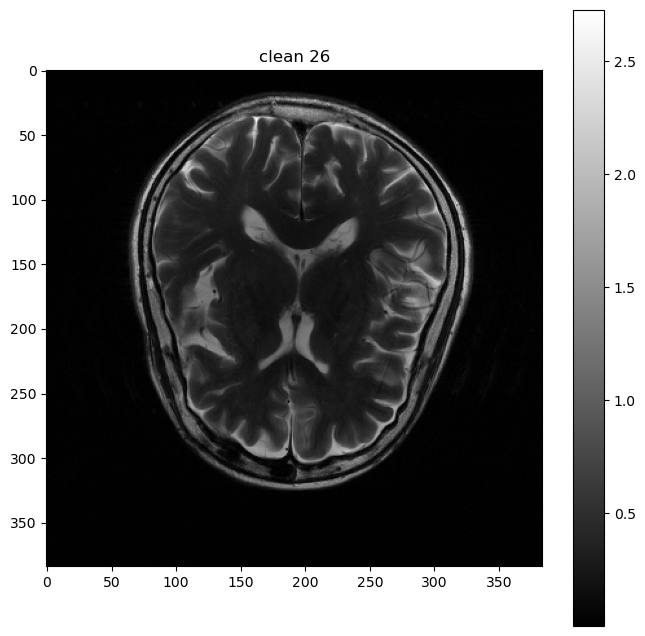

In [ ]:
ind = 26
filepath = "/data/datasets/fastmri/brain_val/32dB/" # filepath to val dir containing ground truths
mask_select = 7                                     # mask R level


data_file = filepath + f"sample_{ind}.pt"
cont = torch.load(data_file)
gt_img = cont['gt'][None,None,...]
dplot(gt_img, "clean 26")
orig_np = torch.abs(gt_img).squeeze().numpy()

# mask_thresh = 0.04
# brain_mask = orig_np > mask_thresh
# plt.figure()
# plt.imshow(brain_mask)

In [ ]:
def in_brain_stats(mean_map, std_map, mask):
    vals_std  = std_map[mask]
    vals_mean = mean_map[mask]
    return vals_std.mean(), (vals_std/vals_mean).mean()

In [7]:
def plot_maps(
    map1, map2,
    savepath,
    vmin=0.0, vmax=0.5,
    figsize=(6, 3), dpi=300,
    fontsize=10
):
    """
    Side-by-side heatmaps with one shared colorbar on the right,
    no axes clutter, no titles, and absolutely zero white border
    between the two panels when saved.
    """

    plt.rcParams.update({
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize * 0.8,
        "ytick.labelsize": fontsize * 0.8,
        "text.usetex": False,
    })

    fig, axes = plt.subplots(1, 2, figsize=figsize, dpi=dpi)

    fig.subplots_adjust(
        left=0.0, right=1.0,
        bottom=0.0, top=1.0,
        wspace=0.0, hspace=0.0
    )

    norm = Normalize(vmin=vmin, vmax=vmax)
    axes[0].imshow(map1, cmap="magma", norm=norm, aspect="equal")
    axes[0].axis("off")
    im2 = axes[1].imshow(map2, cmap="magma", norm=norm, aspect="equal")
    axes[1].axis("off")

    cbar = fig.colorbar(
        im2,
        ax=axes[1],
        fraction=0.046,
        pad=0.02
    )
    cbar.set_label("Std. Dev.", rotation=270, labelpad=12)
    cbar.ax.tick_params(labelsize=fontsize * 0.8)
    
    plt.show()

    fig.savefig(
        savepath,
        dpi=dpi,
        bbox_inches='tight',
        pad_inches=0
    )
    plt.close(fig)


#### Pairwise Comparison of STD Heatmaps:

In [ ]:
# Indices of the validation sample indices to process
inds = [0, 1, 2, 3, 4, 5, 6]
# inds = [19, 26, 44, 55, 136, 137, 170, 174, 194, 208]

# Path to the validation set ground truths
filepath = "/data/datasets/fastmri/brain_val_t1_7/32dB/"

# Dataset size (for data-driven priors). Else just put a string description.
ds = 100

# Contrast type
contrast = "t1"

# Modify based on your saving conventions
base_edm = f"/home/user/heatmaps/mri_edm{ds}_{contrast}_checkpoint_heatmap/uncertainty_run/uncertainty/"
base_padis = f"/home/user/heatmaps/mri_padis{ds}_{contrast}_checkpoint_heatmap/uncertainty_run/uncertainty/"

# outdir/savedir
outdir = "/home/user/val_set_pngs/"

# To compare final metrics for PaDIS-MRI vs. FastMRI-EDM. 
# Can be any two methods but labeled this way for convenience.
padis_arr_mean_std, edm_arr_mean_std = [], []
padis_arr_cv, edm_arr_cv = [], []

for ind in inds:
    cont = torch.load(os.path.join(filepath, f"sample_{ind}.pt"))
    gt_img = cont['gt'][None, None, ...]                     
    orig = np.clip(torch.abs(gt_img).squeeze().numpy(), 0, 1)

    # crop off 32 cols on each side: [384×320]
    orig_crop = orig[:, 32:-32]

    # Otsu threshold + brain mask on cropped image
    mask_thresh = threshold_otsu(orig_crop)
    brain_mask = orig_crop > mask_thresh

    # load mean/std maps
    edm_path = base_edm + str(ind)
    padis_path = base_padis + str(ind)

    mean_edm = np.load(os.path.join(edm_path, "mean_map.npy"))
    std_edm = np.load(os.path.join(edm_path, "std_map.npy"))
    mean_padis = np.load(os.path.join(padis_path, "mean_map.npy"))
    std_padis = np.load(os.path.join(padis_path, "std_map.npy"))

    # squeeze as before, then crop
    def prep(arr):
        a = np.abs(arr).squeeze()
        return a[:, 32:-32]

    mean_edm_c = prep(mean_edm)
    std_edm_c = prep(std_edm)
    mean_padis_c = prep(mean_padis)
    std_padis_c = prep(std_padis)

    # compute in-brain stats on the cropped maps/mask
    edm_std, edm_cv = in_brain_stats(mean_edm_c, std_edm_c, brain_mask)
    padis_std, padis_cv = in_brain_stats(mean_padis_c, std_padis_c, brain_mask)

    padis_arr_mean_std.append(padis_std)
    edm_arr_mean_std.append(edm_std)
    padis_arr_cv.append(padis_cv)
    edm_arr_cv.append(edm_cv)

    print(f"[LEFT] Index {ind}: EDM STD={edm_std:.4f}, Mask Thresh={mask_thresh:.4f}")
    print(f"[RIGHT] Index {ind}: PaDIS STD={padis_std:.4f}, Mask Thresh={mask_thresh:.4f}")

    savedir = outdir + f"heatmap_{contrast}_{ds}_{ind}.png"


    plot_maps(
        std_edm_c,
        std_padis_c,
        savedir,
    )
    
print(f"Summary Statistics for All Images: ")
print(f"EDM Mean STD: {np.array(edm_arr_mean_std).mean()}, EDM Mean CV: {np.array(edm_arr_cv).mean()}")
print(f"PaDIS Mean STD: {np.array(padis_arr_mean_std).mean()}, PaDIS Mean CV: {np.array(padis_arr_cv).mean()}")


#### Single Method Version

In [ ]:
# Indices of the validation sample indices to process
inds = [0, 1, 2, 3, 4, 5, 6]
# inds = [19, 26, 44, 55, 136, 137, 170, 174, 194, 208]

# Path to the validation set ground truths
filepath = "/data/datasets/fastmri/brain_val_t1_7/32dB/"

# Dataset size (for data-driven priors). Else just put a string description.
ds = 100

# Contrast type
contrast = "t1"

base = f"/home/rohan/mri/mri_admm_heatmap_t1/uncertainty_run/uncertainty/{ind}"

# outdir/savedir
outdir = "/home/user/val_set_pngs/"

# To compare final metrics for PaDIS-MRI vs. FastMRI-EDM. 
# Can be any two methods but labeled this way for convenience.
arr_mean_std = []
arr_cv = []

for ind in inds:
    cont = torch.load(os.path.join(filepath, f"sample_{ind}.pt"))
    gt_img = cont['gt'][None, None, ...]                     
    orig = np.clip(torch.abs(gt_img).squeeze().numpy(), 0, 1)

    # crop off 32 cols on each side: [384×320]
    orig_crop = orig[:, 32:-32]

    # Otsu threshold + brain mask on cropped image
    mask_thresh = threshold_otsu(orig_crop)
    brain_mask = orig_crop > mask_thresh

    # load mean/std maps
    full_path = base + str(ind)

    mean_map = np.load(os.path.join(full_path, "mean_map.npy"))
    std_map = np.load(os.path.join(full_path, "std_map.npy"))

    # squeeze as before, then crop
    def prep(arr):
        a = np.abs(arr).squeeze()
        return a[:, 32:-32]

    mean_c = prep(mean_map)
    std_c = prep(std_map)

    # compute in-brain stats on the cropped maps/mask
    std, cv = in_brain_stats(mean_c, std_c, brain_mask)

    arr_mean_std.append(std)
    arr_cv.append(cv)

    print(f"Index {ind}: STD={std:.4f}, Mask Thresh={mask_thresh:.4f}")

    savedir = outdir + f"heatmap_{contrast}_{ds}_{ind}.png"


    plot_maps(
        std_c,
        std_c,
        savedir,
    )
    
print(f"Summary Statistics for All Images: ")
print(f"Mean STD: {np.array(edm_arr_mean_std).mean()}, Mean CV: {np.array(edm_arr_cv).mean()}")
